In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install kaggle==1.5.12

     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=df0a9d9d45358102be090ed682f3783036b7138a0ca88116daf5822266c9a863
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [ ]:
!kaggle --version 

Kaggle API 1.5.12


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/APTOS/

/content/drive/MyDrive/APTOS


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [03:46<00:00, 28.8MB/s]
100% 9.51G/9.51G [03:46<00:00, 45.0MB/s]


In [ ]:
zipData = "/content/drive/MyDrive/APTOS/aptos2019-blindness-detection.zip"
data = "/content/drive/MyDrive/APTOS/data"

In [ ]:
import zipfile
with zipfile.ZipFile(zipData, 'r') as zip_ref:
    zip_ref.extractall(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [ ]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.6.0
/device:GPU:0
Num GPUs Available:  1


# Data Preprocessing

In [ ]:
alv_drivepath = "/content/drive/MyDrive/APTOS-alvee/APTOS/data"

In [ ]:
data = alv_drivepath

In [ ]:
data = "/content/drive/MyDrive/APTOS/data"

In [ ]:
train_df = pd.read_csv(data+'/train.csv')
test_df = pd.read_csv(data+'/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

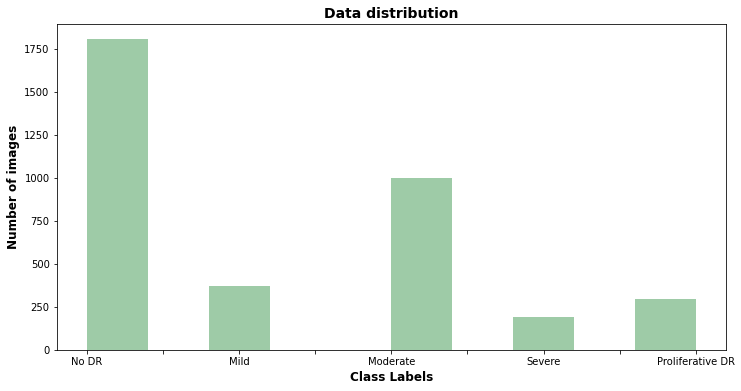

In [ ]:
ax = train_df['diagnosis'].hist(grid= False,  figsize=(12,6), color='#86bf91', alpha=0.8)
ax.set_title("Data distribution", weight='bold', size=14)
ax.set_xticklabels(['','No DR','', 'Mild','', 'Moderate','', 'Severe', '', 'Proliferative DR'])
ax.set_xlabel("Class Labels", weight='bold', size=12)
ax.set_ylabel("Number of images",  weight='bold', size=12)
train_df['diagnosis'].value_counts()

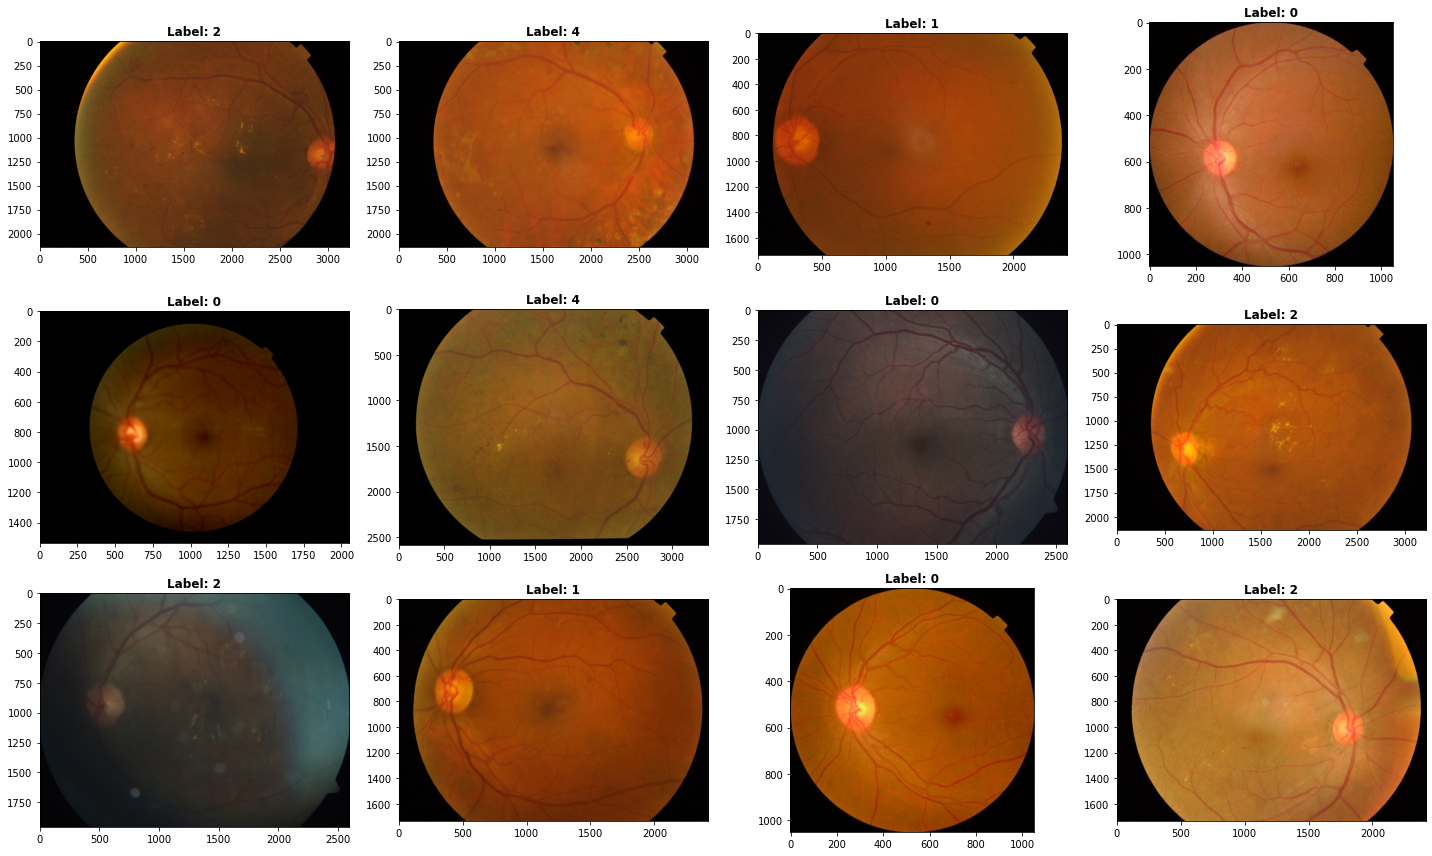

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(data+f'/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title("Label: "+str(image_id), weight='bold')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [ ]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [ ]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        data+f'/train_images/{image_id}.png'
    )

In [ ]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        data+f'/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [10:39<00:00,  3.01it/s]


### Saving X Test and X Train

In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/APTOS/

/content/drive/MyDrive/APTOS


In [ ]:
%cd /content/drive/MyDrive/APTOS-alvee/APTOS/

/content/drive/.shortcut-targets-by-id/13_38BwAQFcG6IaSZSWLk6Juv6oKwye3v/APTOS


In [ ]:
import h5py

with h5py.File('xtrain-aptos.h5', 'w') as hf:
  hf.create_dataset('x_train', data = x_train)

with h5py.File('xtest-aptos.h5', 'w') as hf:
  hf.create_dataset('x_test', data = x_test)

In [ ]:
# Loading the data
import h5py

with h5py.File('xtrain-aptos.h5', 'r') as hf:
  x_train = hf['x_train'][:]
with h5py.File('xtest-aptos.h5', 'r') as hf:
  x_test = hf['x_test'][:]

In [ ]:
y_train_mod = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [ ]:
# Use this for single label classification
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_mod, 
    test_size=0.15, 
    random_state=2019
)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [ ]:
BATCH_SIZE = 32

def create_datagen():
  with tf.device('/device:GPU:0'):
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [ ]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [ ]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

# Building Model With Preloaded Weights

In [ ]:
filepath = "/content/drive/MyDrive/APTOS/singleLabel/best_weights"

### DenseNet121

In [ ]:
densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for DenseNet
checkpoint_filepath = filepath + '/densenet.h5'
dense_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 7,169,349
Trainable params: 7,085,701
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
def fit_model():
  with tf.device('/device:GPU:0'):
    dense_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks =[dense_checkpoint_callback]
    )
    return dense_history

In [ ]:
denseNet_hist = fit_model()

Epoch 1/5
97/97 [==============================] - 132s 854ms/step - loss: 0.8706 - accuracy: 0.6748 - precision_1: 0.7970 - recall_1: 0.5562 - val_loss: 10.9548 - val_accuracy: 0.0764 - val_precision_1: 0.0785 - val_recall_1: 0.0764
Epoch 2/5
97/97 [==============================] - 76s 784ms/step - loss: 0.7002 - accuracy: 0.7301 - precision_1: 0.8391 - recall_1: 0.6067 - val_loss: 3.5552 - val_accuracy: 0.4327 - val_precision_1: 0.4468 - val_recall_1: 0.4273
Epoch 3/5
97/97 [==============================] - 76s 783ms/step - loss: 0.6554 - accuracy: 0.7545 - precision_1: 0.8423 - recall_1: 0.6369 - val_loss: 1.8762 - val_accuracy: 0.7636 - val_precision_1: 0.7636 - val_recall_1: 0.7636
Epoch 4/5
97/97 [==============================] - 77s 783ms/step - loss: 0.6560 - accuracy: 0.7516 - precision_1: 0.8419 - recall_1: 0.6366 - val_loss: 0.7031 - val_accuracy: 0.7164 - val_precision_1: 0.7363 - val_recall_1: 0.6855
Epoch 5/5
97/97 [==============================] - 76s 784ms/step - lo

### Xception

In [ ]:
xception= tf.keras.applications.Xception(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3)
)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for Xception
checkpoint_filepath = filepath + '/xception.h5'
xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_xception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(xception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_xception_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 21,124,397
Trainable params: 21,069,869
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
def fit_xception_model():
  with tf.device('/device:GPU:0'):
    xception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [xception_checkpoint_callback]
    )
    return xception_history

In [ ]:
xception_hist = fit_xception_model()

Epoch 1/5
97/97 [==============================] - 147s 1s/step - loss: 0.8396 - accuracy: 0.7089 - precision_2: 0.8262 - recall_2: 0.5238 - val_loss: 0.8600 - val_accuracy: 0.7782 - val_precision_2: 0.7899 - val_recall_2: 0.7655
Epoch 2/5
97/97 [==============================] - 136s 1s/step - loss: 0.6620 - accuracy: 0.7516 - precision_2: 0.8337 - recall_2: 0.6462 - val_loss: 0.7627 - val_accuracy: 0.7800 - val_precision_2: 0.8096 - val_recall_2: 0.7345
Epoch 3/5
97/97 [==============================] - 136s 1s/step - loss: 0.6101 - accuracy: 0.7674 - precision_2: 0.8447 - recall_2: 0.6710 - val_loss: 0.6324 - val_accuracy: 0.8055 - val_precision_2: 0.8773 - val_recall_2: 0.6891
Epoch 4/5
97/97 [==============================] - 136s 1s/step - loss: 0.5513 - accuracy: 0.7889 - precision_2: 0.8503 - recall_2: 0.7227 - val_loss: 0.4940 - val_accuracy: 0.8218 - val_precision_2: 0.8833 - val_recall_2: 0.7291
Epoch 5/5
97/97 [==============================] - 135s 1s/step - loss: 0.5121 -

### ResNet50

In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for resnet
checkpoint_filepath = filepath + '/resnet50.h5'
resnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_resnet_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_resnet_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 23,850,629
Trainable params: 23,797,509
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def fit_resnet_model():
  with tf.device('/device:GPU:0'):
    resnet_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [resnet_checkpoint_callback]
    )
    return resnet_history

In [ ]:
resnet_hist = fit_resnet_model()

Epoch 1/5
97/97 [==============================] - 86s 790ms/step - loss: 1.1123 - accuracy: 0.6623 - precision_6: 0.8160 - recall_6: 0.4675 - val_loss: 1.4927 - val_accuracy: 0.6400 - val_precision_6: 0.6673 - val_recall_6: 0.6273
Epoch 2/5
97/97 [==============================] - 73s 748ms/step - loss: 0.8060 - accuracy: 0.7143 - precision_6: 0.8312 - recall_6: 0.5697 - val_loss: 1.7841 - val_accuracy: 0.6764 - val_precision_6: 0.7198 - val_recall_6: 0.6400
Epoch 3/5
97/97 [==============================] - 73s 747ms/step - loss: 0.7664 - accuracy: 0.7298 - precision_6: 0.8442 - recall_6: 0.5919 - val_loss: 0.9901 - val_accuracy: 0.7636 - val_precision_6: 0.7757 - val_recall_6: 0.7545
Epoch 4/5
97/97 [==============================] - 73s 749ms/step - loss: 0.6768 - accuracy: 0.7468 - precision_6: 0.8399 - recall_6: 0.6337 - val_loss: 0.8092 - val_accuracy: 0.7764 - val_precision_6: 0.7989 - val_recall_6: 0.7655
Epoch 5/5
97/97 [==============================] - 73s 748ms/step - loss

### VGG16

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for vgg16
checkpoint_filepath = filepath + '/vgg16.h5'
vgg16_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg16_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg16)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg16_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 14,780,997
Trainable params: 14,780,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg16_model():
  with tf.device('/device:GPU:0'):
    vgg16_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [vgg16_checkpoint_callback]
    )
    return vgg16_history

In [ ]:
vgg16_hist = fit_vgg16_model()

Epoch 1/5
97/97 [==============================] - 103s 896ms/step - loss: 2.5817 - accuracy: 0.4884 - precision_7: 0.6595 - recall_7: 0.2465 - val_loss: 0.9264 - val_accuracy: 0.6582 - val_precision_7: 0.9563 - val_recall_7: 0.3982
Epoch 2/5
97/97 [==============================] - 79s 814ms/step - loss: 1.0398 - accuracy: 0.6449 - precision_7: 0.8571 - recall_7: 0.3914 - val_loss: 0.8353 - val_accuracy: 0.7455 - val_precision_7: 0.9462 - val_recall_7: 0.4473
Epoch 3/5
97/97 [==============================] - 80s 817ms/step - loss: 0.9367 - accuracy: 0.6873 - precision_7: 0.8336 - recall_7: 0.4749 - val_loss: 0.8704 - val_accuracy: 0.7327 - val_precision_7: 0.9447 - val_recall_7: 0.4345
Epoch 4/5
97/97 [==============================] - 79s 812ms/step - loss: 0.8961 - accuracy: 0.7040 - precision_7: 0.8033 - recall_7: 0.5196 - val_loss: 0.7709 - val_accuracy: 0.7455 - val_precision_7: 0.7560 - val_recall_7: 0.6818
Epoch 5/5
97/97 [==============================] - 79s 821ms/step - los

### VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for vgg19
checkpoint_filepath = filepath + '/vgg19.h5'
vgg19_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg19_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg19)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg19_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 645       
Total params: 20,090,693
Trainable params: 20,090,693
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg19_model():
  with tf.device('/device:GPU:0'):
    vgg19_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [vgg19_checkpoint_callback]
    )
    return vgg19_history

In [ ]:
vgg19_hist = fit_vgg19_model()

Epoch 1/5
97/97 [==============================] - 96s 966ms/step - loss: 2.7741 - accuracy: 0.4441 - precision_8: 0.4425 - recall_8: 0.1767 - val_loss: 1.2267 - val_accuracy: 0.5200 - val_precision_8: 0.5919 - val_recall_8: 0.4509
Epoch 2/5
97/97 [==============================] - 93s 951ms/step - loss: 1.3386 - accuracy: 0.4688 - precision_8: 0.5405 - recall_8: 0.1610 - val_loss: 1.2592 - val_accuracy: 0.5200 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/5
97/97 [==============================] - 93s 953ms/step - loss: 1.3114 - accuracy: 0.4785 - precision_8: 0.5441 - recall_8: 0.1706 - val_loss: 1.1526 - val_accuracy: 0.5200 - val_precision_8: 1.0000 - val_recall_8: 0.1291
Epoch 4/5
97/97 [==============================] - 92s 946ms/step - loss: 1.3483 - accuracy: 0.4737 - precision_8: 0.5288 - recall_8: 0.1976 - val_loss: 1.2399 - val_accuracy: 0.5182 - val_precision_8: 0.6491 - val_recall_8: 0.1345
Epoch 5/5
97/97 [==============================] - 92s 946ms/ste

### Inception


In [ ]:
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for Inception
checkpoint_filepath = filepath + '/inception.h5'
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_inception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(inception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_inception_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 645       
Total params: 22,065,701
Trainable params: 22,031,269
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
def fit_inception_model():
  with tf.device('/device:GPU:0'):
    inception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [inception_checkpoint_callback]
    )
    return inception_history

In [ ]:
inception_hist = fit_inception_model()

Epoch 1/5
97/97 [==============================] - 75s 647ms/step - loss: 0.9737 - accuracy: 0.6671 - precision_9: 0.8174 - recall_9: 0.4878 - val_loss: 1.2817 - val_accuracy: 0.7345 - val_precision_9: 0.7712 - val_recall_9: 0.7291
Epoch 2/5
97/97 [==============================] - 58s 596ms/step - loss: 0.7921 - accuracy: 0.7304 - precision_9: 0.8484 - recall_9: 0.5774 - val_loss: 1.6050 - val_accuracy: 0.7636 - val_precision_9: 0.7753 - val_recall_9: 0.7527
Epoch 3/5
97/97 [==============================] - 58s 597ms/step - loss: 0.7068 - accuracy: 0.7497 - precision_9: 0.8502 - recall_9: 0.6183 - val_loss: 0.8053 - val_accuracy: 0.7764 - val_precision_9: 0.8408 - val_recall_9: 0.6818
Epoch 4/5
97/97 [==============================] - 58s 596ms/step - loss: 0.6414 - accuracy: 0.7567 - precision_9: 0.8515 - recall_9: 0.6485 - val_loss: 0.5259 - val_accuracy: 0.8091 - val_precision_9: 0.8603 - val_recall_9: 0.7727
Epoch 5/5
97/97 [==============================] - 58s 597ms/step - loss

## Visualization

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

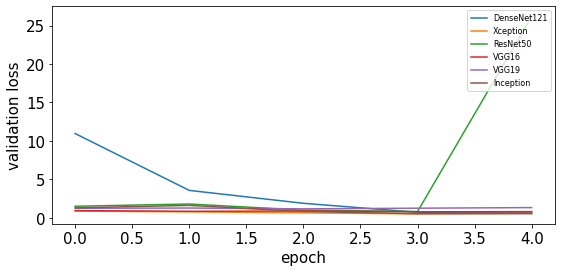

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_loss'])
plt.plot(xception_hist.history['val_loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.plot(vgg16_hist.history['val_loss'])
plt.plot(vgg19_hist.history['val_loss'])
plt.plot(inception_hist.history['val_loss'])
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

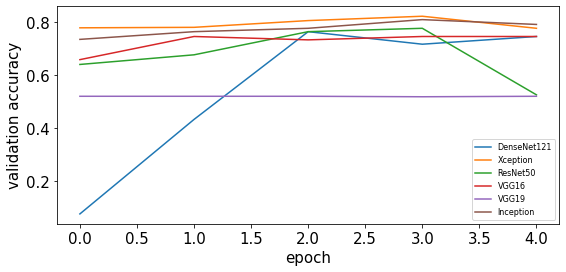

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_accuracy'])
plt.plot(xception_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(vgg16_hist.history['val_accuracy'])
plt.plot(vgg19_hist.history['val_accuracy'])
plt.plot(inception_hist.history['val_accuracy'])
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='lower right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
xception_hist.history

{'accuracy': [0.8884961605072021, 0.9733290672302246],
 'loss': [0.19109489023685455, 0.13752126693725586],
 'precision_14': [0.927563488483429, 0.9445213079452515],
 'val_accuracy': [1.0, 0.9127272963523865],
 'val_loss': [0.5322237014770508, 0.1626356989145279],
 'val_precision_14': [0.9635258316993713, 0.8867313861846924]}

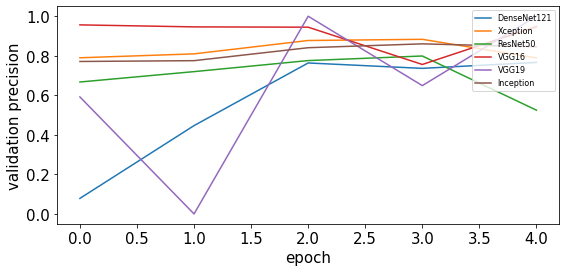

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_precision_1'])
plt.plot(xception_hist.history['val_precision_2'])
plt.plot(resnet_hist.history['val_precision_6'])
plt.plot(vgg16_hist.history['val_precision_7'])
plt.plot(vgg19_hist.history['val_precision_8'])
plt.plot(inception_hist.history['val_precision_9'])
plt.ylabel('validation precision')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

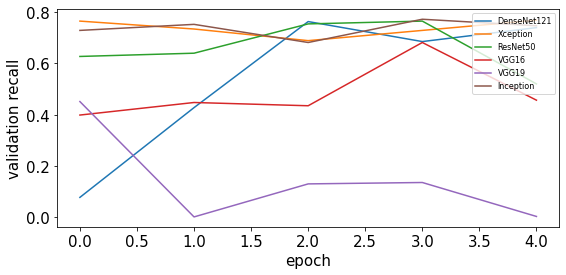

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_recall_1'])
plt.plot(xception_hist.history['val_recall_2'])
plt.plot(resnet_hist.history['val_recall_6'])
plt.plot(vgg16_hist.history['val_recall_7'])
plt.plot(vgg19_hist.history['val_recall_8'])
plt.plot(inception_hist.history['val_recall_9'])
plt.ylabel('validation recall')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

# Building Model With Random Initialization of Weights

In [ ]:
import pickle

### DenseNet121

In [ ]:
filepath = "/content/drive/MyDrive/APTOS/singleLabel/best_weights_rand"

In [ ]:
alv_filepath = "/content/drive/MyDrive/APTOS-alvee/APTOS/singleLabel/best_weights_rand"

In [ ]:
filepath = alv_filepath

In [ ]:
history_filepath = "/content/drive/MyDrive/APTOS/singleLabel/best_weights_rand/history"

In [ ]:
alv_history_filepath = "/content/drive/MyDrive/APTOS-alvee/APTOS/singleLabel/best_weights_rand/history"
history_filepath = alv_history_filepath

In [ ]:
densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for DenseNet
checkpoint_filepath = filepath + '/densenet.h5'
dense_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 7,169,349
Trainable params: 7,085,701
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
def fit_model():
  with tf.device('/device:GPU:0'):
    dense_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks =[dense_checkpoint_callback]
    )
    return dense_history

In [ ]:
denseNet_hist = fit_model()

Epoch 1/10
97/97 [==============================] - 134s 866ms/step - loss: 1.0924 - accuracy: 0.6157 - precision: 0.7610 - recall: 0.4296 - val_loss: 6.6347 - val_accuracy: 0.5200 - val_precision: 0.5191 - val_recall: 0.5182
Epoch 2/10
97/97 [==============================] - 78s 803ms/step - loss: 0.9607 - accuracy: 0.6581 - precision: 0.8022 - recall: 0.4717 - val_loss: 4.5112 - val_accuracy: 0.5236 - val_precision: 0.5476 - val_recall: 0.5127
Epoch 3/10
97/97 [==============================] - 77s 794ms/step - loss: 0.8834 - accuracy: 0.6883 - precision: 0.8113 - recall: 0.5305 - val_loss: 1.6572 - val_accuracy: 0.4582 - val_precision: 0.4924 - val_recall: 0.2964
Epoch 4/10
97/97 [==============================] - 77s 794ms/step - loss: 0.8791 - accuracy: 0.6899 - precision: 0.8133 - recall: 0.5209 - val_loss: 2.5103 - val_accuracy: 0.3055 - val_precision: 0.3402 - val_recall: 0.1800
Epoch 5/10
97/97 [==============================] - 77s 794ms/step - loss: 0.8637 - accuracy: 0.702

In [ ]:
np.save(history_filepath +'/denseNet_hist.npy', denseNet_hist.history) 

### Xception

In [ ]:
xception= tf.keras.applications.Xception(
    include_top=False, weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for Xception
checkpoint_filepath = filepath + '/xception.h5'
xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_xception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(xception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_xception_model()
print(model)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 21,124,397
Trainable params: 21,069,869
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
def fit_xception_model():
  with tf.device('/device:GPU:0'):
    xception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks = [xception_checkpoint_callback]
    )
    return xception_history

In [ ]:
xception_hist = fit_xception_model()

Epoch 1/10
97/97 [==============================] - 140s 1s/step - loss: 1.1049 - accuracy: 0.6147 - precision_5: 0.7678 - recall_5: 0.4219 - val_loss: 1.5971 - val_accuracy: 0.2709 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/10
97/97 [==============================] - 129s 1s/step - loss: 0.9645 - accuracy: 0.6597 - precision_5: 0.8141 - recall_5: 0.4727 - val_loss: 1.5983 - val_accuracy: 0.2709 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/10
97/97 [==============================] - 129s 1s/step - loss: 0.9457 - accuracy: 0.6742 - precision_5: 0.8114 - recall_5: 0.4978 - val_loss: 1.6310 - val_accuracy: 0.2709 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/10
97/97 [==============================] - 129s 1s/step - loss: 0.9246 - accuracy: 0.6883 - precision_5: 0.8127 - recall_5: 0.5145 - val_loss: 1.6289 - val_accuracy: 0.3109 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/10
97/97 [==========================

In [ ]:
np.save(history_filepath +'/xception_hist.npy', xception_hist.history) 

### ResNet50

In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for resnet
checkpoint_filepath = filepath + '/resnet50.h5'
resnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_resnet_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

In [ ]:
model = build_resnet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 23,850,629
Trainable params: 23,797,509
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def fit_resnet_model():
  with tf.device('/device:GPU:0'):
    resnet_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks = [resnet_checkpoint_callback]
    )
    return resnet_history

In [ ]:
resnet_hist = fit_resnet_model()

Epoch 1/10
97/97 [==============================] - 113s 753ms/step - loss: 1.6982 - accuracy: 0.5096 - precision: 0.6378 - recall: 0.2982 - val_loss: 108.2939 - val_accuracy: 0.5182 - val_precision: 0.5184 - val_recall: 0.5127
Epoch 2/10
97/97 [==============================] - 71s 725ms/step - loss: 1.0995 - accuracy: 0.6176 - precision: 0.7875 - recall: 0.3978 - val_loss: 2.6526 - val_accuracy: 0.5509 - val_precision: 0.5957 - val_recall: 0.5036
Epoch 3/10
97/97 [==============================] - 70s 721ms/step - loss: 1.0272 - accuracy: 0.6491 - precision: 0.8226 - recall: 0.4322 - val_loss: 2.2224 - val_accuracy: 0.5364 - val_precision: 0.5504 - val_recall: 0.4964
Epoch 4/10
97/97 [==============================] - 72s 739ms/step - loss: 0.9849 - accuracy: 0.6645 - precision: 0.8316 - recall: 0.4476 - val_loss: 5.0987 - val_accuracy: 0.5200 - val_precision: 0.5230 - val_recall: 0.5164
Epoch 5/10
97/97 [==============================] - 71s 723ms/step - loss: 1.0069 - accuracy: 0.6

In [ ]:
np.save(history_filepath +'/resnet_hist.npy', resnet_hist.history) 

### VGG16

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for vgg16
checkpoint_filepath = filepath + '/vgg16.h5'
vgg16_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg16_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg16)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg16_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 14,780,997
Trainable params: 14,780,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg16_model():
  with tf.device('/device:GPU:0'):
    vgg16_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks = [vgg16_checkpoint_callback]
    )
    return vgg16_history

In [ ]:
vgg16_hist = fit_vgg16_model()

Epoch 1/10
97/97 [==============================] - 98s 852ms/step - loss: 13.1815 - accuracy: 0.4569 - precision_1: 0.7206 - recall_1: 0.2089 - val_loss: 0.9483 - val_accuracy: 0.5200 - val_precision_1: 0.9476 - val_recall_1: 0.4273
Epoch 2/10
97/97 [==============================] - 76s 781ms/step - loss: 1.0637 - accuracy: 0.6195 - precision_1: 0.9105 - recall_1: 0.3692 - val_loss: 0.8510 - val_accuracy: 0.7073 - val_precision_1: 0.9520 - val_recall_1: 0.4327
Epoch 3/10
97/97 [==============================] - 76s 776ms/step - loss: 1.0664 - accuracy: 0.6430 - precision_1: 0.8435 - recall_1: 0.3811 - val_loss: 1.2470 - val_accuracy: 0.5200 - val_precision_1: 0.6250 - val_recall_1: 0.0091
Epoch 4/10
97/97 [==============================] - 76s 777ms/step - loss: 1.0556 - accuracy: 0.6494 - precision_1: 0.8410 - recall_1: 0.3891 - val_loss: 0.8915 - val_accuracy: 0.6673 - val_precision_1: 0.9189 - val_recall_1: 0.4327
Epoch 5/10
97/97 [==============================] - 76s 778ms/step 

In [ ]:
np.save(history_filepath +'/vgg16_hist.npy', vgg16_hist.history) 

### VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for vgg19
checkpoint_filepath = filepath + '/vgg19.h5'
vgg19_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg19_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg19)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg19_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 20,090,693
Trainable params: 20,090,693
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg19_model():
  with tf.device('/device:GPU:0'):
    vgg19_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks = [vgg19_checkpoint_callback]
    )
    return vgg19_history

In [ ]:
vgg19_hist = fit_vgg19_model()

Epoch 1/10
97/97 [==============================] - 92s 924ms/step - loss: 101.5639 - accuracy: 0.4592 - precision_2: 0.6341 - recall_2: 0.1710 - val_loss: 1.0427 - val_accuracy: 0.5200 - val_precision_2: 0.9602 - val_recall_2: 0.3945
Epoch 2/10
97/97 [==============================] - 89s 917ms/step - loss: 1.0887 - accuracy: 0.5746 - precision_2: 0.9205 - recall_2: 0.3310 - val_loss: 0.8776 - val_accuracy: 0.6927 - val_precision_2: 0.9558 - val_recall_2: 0.4327
Epoch 3/10
97/97 [==============================] - 89s 922ms/step - loss: 1.0180 - accuracy: 0.6546 - precision_2: 0.8777 - recall_2: 0.3965 - val_loss: 0.9089 - val_accuracy: 0.6909 - val_precision_2: 0.9597 - val_recall_2: 0.4327
Epoch 4/10
97/97 [==============================] - 89s 917ms/step - loss: 1.0085 - accuracy: 0.6684 - precision_2: 0.8256 - recall_2: 0.4274 - val_loss: 0.8617 - val_accuracy: 0.6927 - val_precision_2: 0.9597 - val_recall_2: 0.4327
Epoch 5/10
97/97 [==============================] - 89s 917ms/step

In [ ]:
np.save(history_filepath +'/vgg19_hist.npy', vgg19_hist.history) 

### Inception

In [ ]:
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for Inception
checkpoint_filepath = filepath + '/inception.h5'
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_inception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(inception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_inception_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total params: 22,065,701
Trainable params: 22,031,269
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
def fit_inception_model():
  with tf.device('/device:GPU:0'):
    inception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks = [inception_checkpoint_callback]
    )
    return inception_history

In [ ]:
inception_hist = fit_inception_model()

Epoch 1/10
97/97 [==============================] - 73s 631ms/step - loss: 1.2933 - accuracy: 0.5868 - precision_3: 0.7181 - recall_3: 0.3904 - val_loss: 18.4582 - val_accuracy: 0.5618 - val_precision_3: 0.5942 - val_recall_3: 0.4873
Epoch 2/10
97/97 [==============================] - 57s 580ms/step - loss: 0.9962 - accuracy: 0.6555 - precision_3: 0.8064 - recall_3: 0.4512 - val_loss: 0.9072 - val_accuracy: 0.7000 - val_precision_3: 0.9091 - val_recall_3: 0.4000
Epoch 3/10
97/97 [==============================] - 57s 581ms/step - loss: 0.9829 - accuracy: 0.6626 - precision_3: 0.8035 - recall_3: 0.4692 - val_loss: 57.7111 - val_accuracy: 0.5345 - val_precision_3: 0.5495 - val_recall_3: 0.5145
Epoch 4/10
97/97 [==============================] - 57s 579ms/step - loss: 0.9579 - accuracy: 0.6780 - precision_3: 0.8067 - recall_3: 0.4775 - val_loss: 1.8675 - val_accuracy: 0.5018 - val_precision_3: 0.6056 - val_recall_3: 0.3964
Epoch 5/10
97/97 [==============================] - 57s 579ms/step

In [ ]:
np.save(history_filepath +'/inception_hist.npy', inception_hist.history) 

# Visualization

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

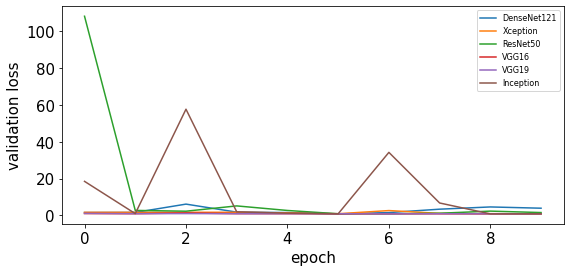

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_loss'])
plt.plot(xception_hist.history['val_loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.plot(vgg16_hist.history['val_loss'])
plt.plot(vgg19_hist.history['val_loss'])
plt.plot(inception_hist.history['val_loss'])
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

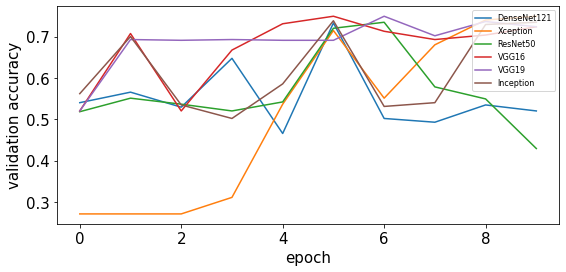

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_accuracy'])
plt.plot(xception_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(vgg16_hist.history['val_accuracy'])
plt.plot(vgg19_hist.history['val_accuracy'])
plt.plot(inception_hist.history['val_accuracy'])
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
inception_hist = np.load(history_filepath +'/inception_hist.npy', allow_pickle=True)
denseNet_hist = np.load(history_filepath +'/denseNet_hist.npy', allow_pickle=True)
xception_hist = np.load(history_filepath +'/xception_hist.npy', allow_pickle=True)
resnet_hist = np.load(history_filepath +'/resnet_hist.npy', allow_pickle=True)
vgg16_hist = np.load(history_filepath +'/vgg16_hist.npy', allow_pickle=True)
vgg19_hist = np.load(history_filepath +'/vgg19_hist.npy', allow_pickle=True)

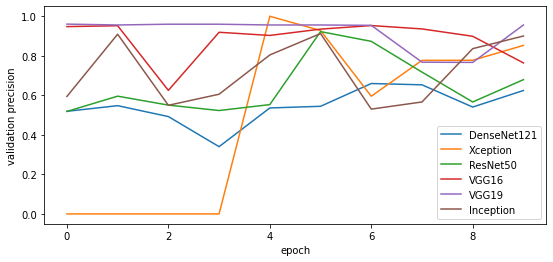

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot([0.5191256999969482, 0.5475727915763855, 0.4924471378326416, 0.34020617604255676, 0.5360824465751648, 0.5444015264511108, 0.6596305966377258, 0.6531645655632019, 0.5406427383422852, 0.6243386268615723])
plt.plot([0.0, 0.0, 0.0, 0.0, 1.0, 0.9277978539466858, 0.5953878164291382, 0.7766990065574646, 0.7773279547691345, 0.8525000214576721])
plt.plot([0.5183823704719543, 0.5956989526748657, 0.5504032373428345, 0.5230202674865723, 0.5530145764350891, 0.9222614765167236, 0.8729729652404785, 0.717391312122345, 0.5662650465965271, 0.6792452931404114])
plt.plot([0.9475806355476379, 0.9520000219345093, 0.625, 0.9189189076423645, 0.9029126167297363, 0.9347826242446899, 0.9529411792755127, 0.9358490705490112, 0.8986486196517944, 0.7638603448867798])
plt.plot([0.9601770043373108, 0.9558233022689819, 0.9596773982048035, 0.9596773982048035, 0.9558233022689819, 0.9558233022689819, 0.954023003578186, 0.7675906419754028, 0.7664543390274048, 0.9558233022689819])
plt.plot( [0.5942350625991821, 0.9090909361839294, 0.5495145916938782, 0.605555534362793, 0.8041958212852478, 0.9124578833580017, 0.5301645398139954, 0.5663366317749023, 0.8361111283302307, 0.8999999761581421])
plt.ylabel('validation precision')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='lower right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

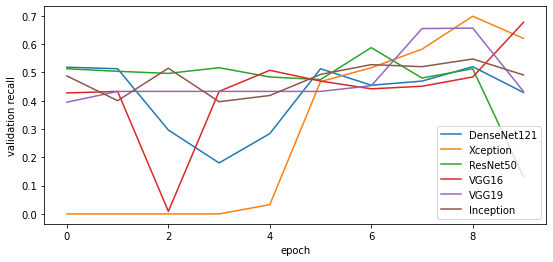

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot( [0.5181818008422852, 0.5127272605895996, 0.29636362195014954, 0.18000000715255737, 0.2836363613605499, 0.5127272605895996, 0.4545454680919647, 0.46909090876579285, 0.5199999809265137, 0.4290909171104431])
plt.plot([0.0, 0.0, 0.0, 0.0, 0.03272727131843567, 0.46727272868156433, 0.5163636207580566, 0.581818163394928, 0.6981818079948425, 0.6200000047683716])
plt.plot([0.5127272605895996, 0.503636360168457, 0.49636363983154297, 0.5163636207580566, 0.48363634943962097, 0.4745454490184784, 0.5872727036476135, 0.47999998927116394, 0.5127272605895996, 0.13090908527374268])
plt.plot([0.4272727370262146, 0.43272727727890015, 0.00909090880304575, 0.43272727727890015, 0.5072727203369141, 0.46909090876579285, 0.4418181777000427, 0.4509090781211853, 0.48363634943962097, 0.6763636469841003])
plt.plot([0.39454546570777893, 0.43272727727890015, 0.43272727727890015, 0.43272727727890015, 0.43272727727890015, 0.43272727727890015, 0.4527272582054138, 0.6545454263687134, 0.6563636660575867, 0.43272727727890015])
plt.plot([0.4872727394104004, 0.4000000059604645, 0.5145454406738281, 0.39636364579200745, 0.41818180680274963, 0.49272727966308594, 0.5272727012634277, 0.5199999809265137, 0.5472727417945862, 0.4909090995788574])
plt.ylabel('validation recall')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='lower right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

### Proposed Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.utils import np_utils
from sklearn import metrics

In [ ]:
# Checkpoint to save the best weights for Inception
checkpoint_filepath = filepath + '/custom_model.h5'
customModel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_custom_model():
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(224,224,3)))
    model.add(MaxPooling2D(padding="same"))

    model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
    model.add(MaxPooling2D(padding="same"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(layers.Flatten())

    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(5,activation='softmax'))
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(),
      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_custom_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 128)       512       
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0

In [ ]:
def fit_custom_model(model):
  with tf.device('/device:GPU:0'):
    custom_model_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks = [customModel_checkpoint_callback]
    )
    return custom_model_history

In [ ]:
custom_hist = fit_custom_model(model)

Epoch 1/10
97/97 [==============================] - 80s 452ms/step - loss: 6.0796 - accuracy: 0.5231 - precision: 0.5883 - recall: 0.3959 - val_loss: 2.0391 - val_accuracy: 0.6582 - val_precision: 0.7804 - val_recall: 0.5491
Epoch 2/10
97/97 [==============================] - 43s 443ms/step - loss: 1.2554 - accuracy: 0.5656 - precision: 0.8635 - recall: 0.2988 - val_loss: 0.9480 - val_accuracy: 0.6673 - val_precision: 0.9375 - val_recall: 0.4091
Epoch 3/10
97/97 [==============================] - 44s 446ms/step - loss: 1.1582 - accuracy: 0.5762 - precision: 0.9007 - recall: 0.3091 - val_loss: 0.9784 - val_accuracy: 0.7018 - val_precision: 0.9109 - val_recall: 0.4091
Epoch 4/10
97/97 [==============================] - 43s 443ms/step - loss: 1.1990 - accuracy: 0.5305 - precision: 0.9062 - recall: 0.2516 - val_loss: 0.9099 - val_accuracy: 0.6855 - val_precision: 0.9395 - val_recall: 0.4236
Epoch 5/10
97/97 [==============================] - 42s 434ms/step - loss: 1.2377 - accuracy: 0.5530